In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets

In [2]:
root_folder = os.path.join(raw_folder, 'third_attempt')

In [3]:
folders_list = sorted(os.listdir(root_folder))
type_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(type_dropdown)

Dropdown(description='source: ', index=1, options=('test', 'train'), value='train')

In [4]:
folders_list = sorted(os.listdir(os.path.join(root_folder, type_dropdown.value)))
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='folder: ',
)
display(folder_dropdown)

Dropdown(description='folder: ', index=3, options=('1039-2088DA037-3', '1039-2088DA037-4', '1039-2088DA039-3',…

In [8]:
annotation_folder = os.path.join(root_folder, type_dropdown.value, folder_dropdown.value)
print(annotation_folder)
print(os.path.isdir(annotation_folder))
tifs = sorted(glob.glob( annotation_folder + '/*.tif'))
print('no of tifs: {}'.format(len(tifs)))

/media/mehrtash/mehrtash2/qanat/raw/third_attempt/train/1039-2088DA037-3
True
no of tifs: 1


In [9]:
image_index = 0
tif_path = tifs[image_index]
image = sitk.ReadImage(tif_path)
nda = sitk.GetArrayFromImage(image)

In [10]:
labels = sorted(glob.glob(os.path.join(root_folder, type_dropdown.value, folder_dropdown.value) + '/' + '*label_*.nrrd'))
print('no of labels: {}'.format(len(labels)))

no of labels: 2


In [173]:
label_index = 0
label_path = labels[label_index]
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)

In [175]:
print(label_path)
roi_path = label_path.replace('.nrrd', '_roi.acsv')
print(roi_path)
print(os.path.isfile(roi_path))

/media/mehrtash/mehrtash2/qanat/raw/third_attempt/train/1039-2088DA037-3/1039-2088DA037-3-label_1.nrrd
/media/mehrtash/mehrtash2/qanat/raw/third_attempt/train/1039-2088DA037-3/1039-2088DA037-3-label_1_roi.acsv
True


In [176]:
roi = np.zeros((2,2))
i = 0
with open(roi_path) as f:
    for line in f.readlines():
        if line.startswith('point'):
            p = line.split('|')
            roi[i,0] = -float(p[1])
            roi[i,1] = -float(p[2])
            i += 1

In [177]:
center = list(roi[0])
center = np.asarray(image.TransformPhysicalPointToIndex(center))
spacing = image.GetSpacing()
length = np.abs(roi[1]/spacing).astype(np.int)
start = center - length
end = center + length
print(start,end)

[6581 5227] [8585 7231]


In [178]:
import matplotlib.pyplot as plt
%matplotlib inline

In [179]:
from matplotlib import colors
cmap = colors.ListedColormap(['orange', 'red'])

In [180]:
nda.shape
#nda[start[1]:end[1], start[0]:end[0]].shape

(7796, 18625)

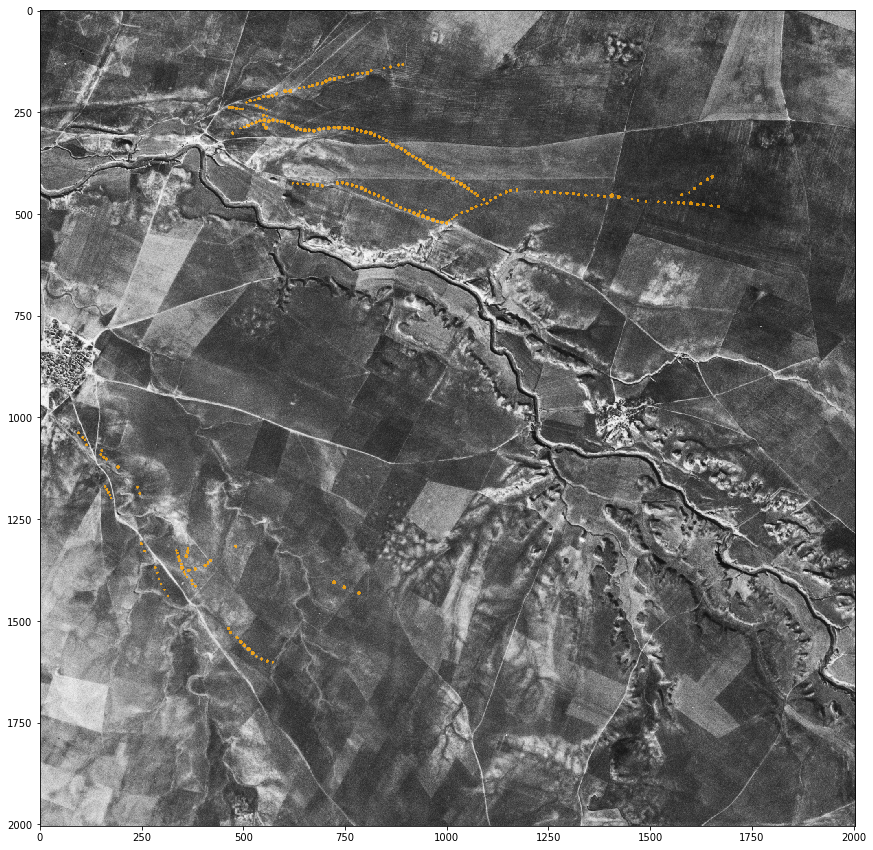

In [181]:
#
plt.figure(figsize=(15,15))
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.8, cmap=cmap)

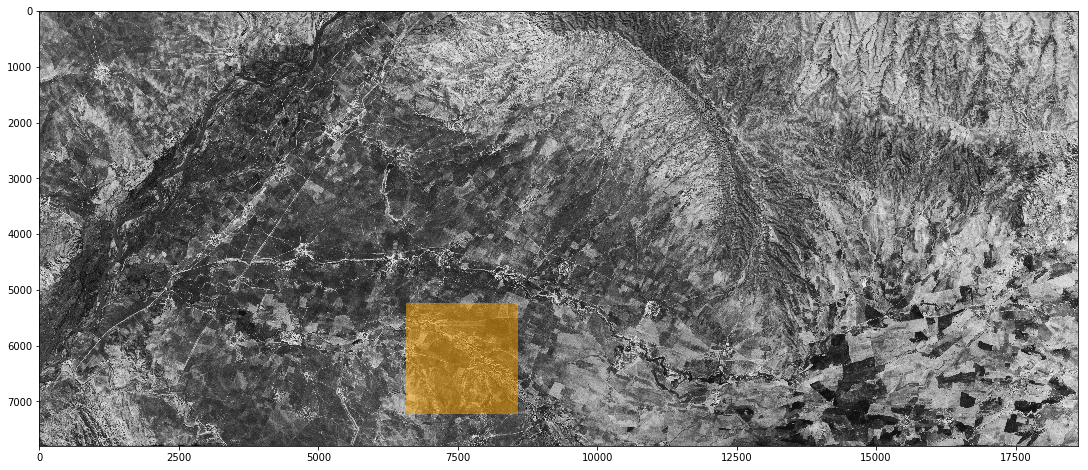

In [182]:
plt.figure(figsize=(24,8))
annotation_area = np.zeros_like(nda)
annotation_area[start[1]:end[1], start[0]:end[0]] = 255
annotation_area = np.ma.masked_where(annotation_area== 0, annotation_area)
plt.imshow(nda, cmap=plt.cm.gray)
plt.imshow(annotation_area, alpha=0.5,  cmap=cmap)

In [183]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap, ccf_labelmap)
labels = list(stats_filter.GetLabels())
labels.remove(0)
print(len(labels))

236


In [184]:
changeFilter = sitk.ChangeLabelImageFilter()
changeMap = sitk.DoubleDoubleMap()
for label_val in labels:
    changeMap[label_val] = int(np.random.randint(0,255,1)[0])
ccf_labelmap_random = changeFilter.Execute(ccf_labelmap, changeMap)

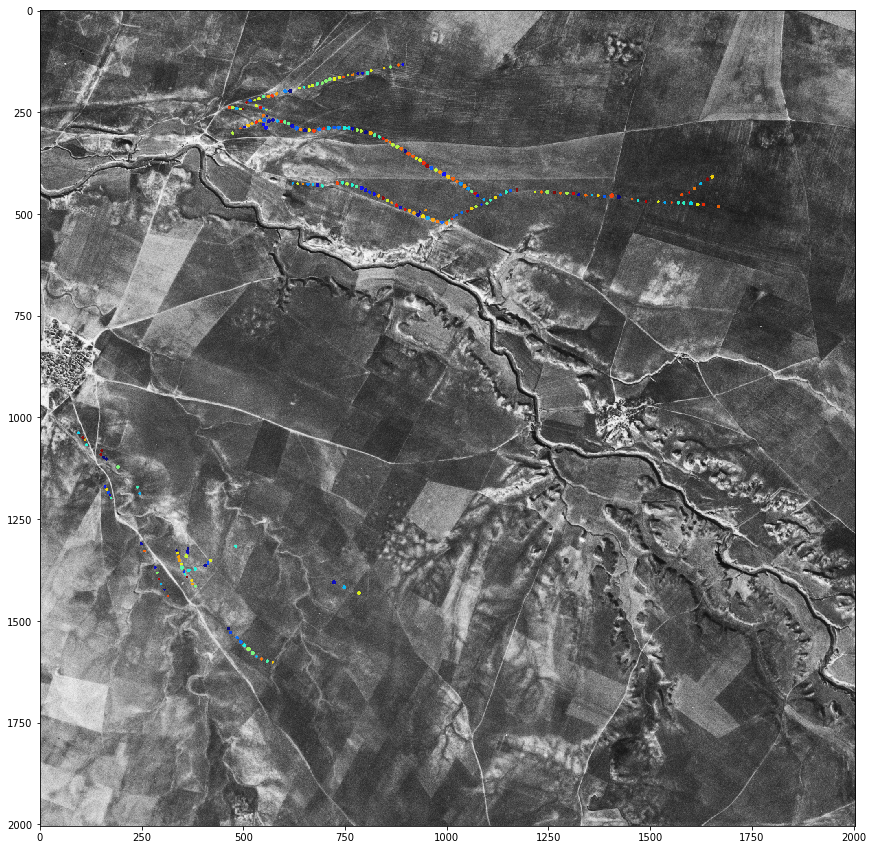

In [185]:
plt.figure(figsize=(15,15))
label_nda = sitk.GetArrayFromImage(ccf_labelmap_random).squeeze()
label_mask = np.ma.masked_where(label_nda== 0, label_nda)
plt.imshow(nda[start[1]:end[1], start[0]:end[0]], cmap=plt.cm.gray)
plt.imshow(label_mask[start[1]:end[1], start[0]:end[0]], alpha=0.9,cmap=plt.cm.jet)

In [186]:
d = []
pd.DataFrame(d)
for label_value in labels:
    bb = np.asarray(stats_filter.GetBoundingBox(label_value))
    d.append({'label': label_value, 'count': stats_filter.GetCount(label_value), 'x': int( bb[0] + (bb[1]-bb[0])/2), 
              'y': int(bb[2] + (bb[3]-bb[2])/2)}) 

In [187]:
df = pd.DataFrame(d)

In [188]:
len(df)

236

In [194]:
largest = df.sort_values('count', ascending=False).head(40)
smallest = df.sort_values('count', ascending=True).head(40)
largest

count  label     x     y
13     216     14  7283  5401
40     137     41  7147  5498
47     130     48  7133  5512
46     124     47  7096  5508
45     114     46  7187  5503
202    108    203  6922  6574
167    108    168  7510  5726
129    105    130  7984  5682
185     99    186  6740  6327
15      96     16  7245  5412
5       82      6  7384  5381
78      81     79  7485  5579
115     80    116  7826  5673
39      80     40  7131  5497
207     80    208  6929  6596
173     80    174  7545  5741
95      80     96  7614  5653
75      80     76  7458  5562
51      80     52  7313  5515
171     80    172  7521  5733
221     80    222  7327  6644
109     80    110  7632  5665
82      80     83  7523  5602
53      80     54  7328  5516
88      80     89  8231  5635
18      80     19  7194  5425
48      80     49  7200  5512
54      79     55  7210  5517
90      79     91  7594  5641
201     79    202  6939  6567
67      79     68  7392  5528
87      79     88  7572  5629
59      79     60  7266  5519
186     79    187  6772  6349
168     79    169  7498  5724
85      79     86  7552  5619
172     79    173  7532  5737
231     79    232  7102  6805
19      79     20  7183  5426
84      79     85  7541  5613

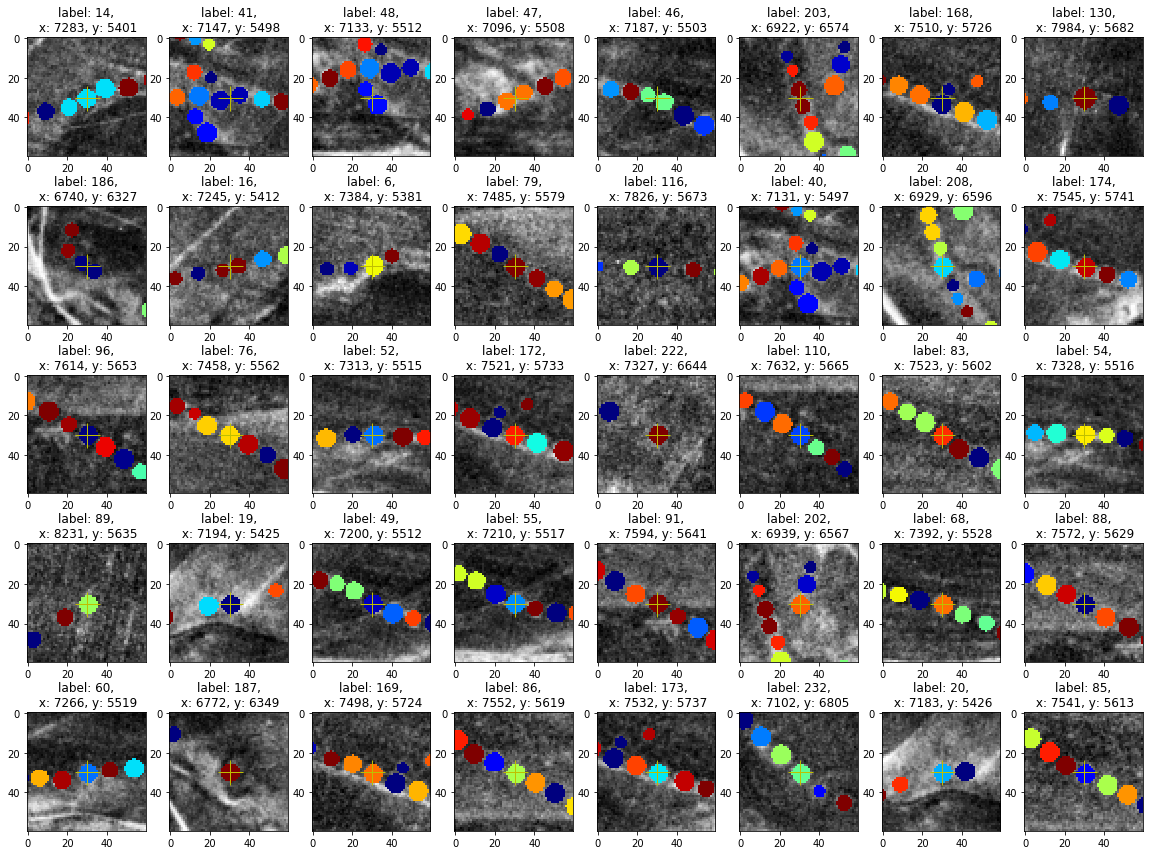

In [206]:
fig, axs = plt.subplots(5,8, figsize=(20, 15), facecolor='w', edgecolor='k')
pad = 30
axs = axs.ravel()
i = 0
for index, row in largest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=1, cmap=plt.cm.jet)
    axs[i].set_title('label: {},\n x: {}, y: {}'.format(label_val, x, y))
    axs[i].plot(pad,pad, 'y+', markersize=25,lw=2)
    i +=1

IndexError: index 25 is out of bounds for axis 0 with size 25

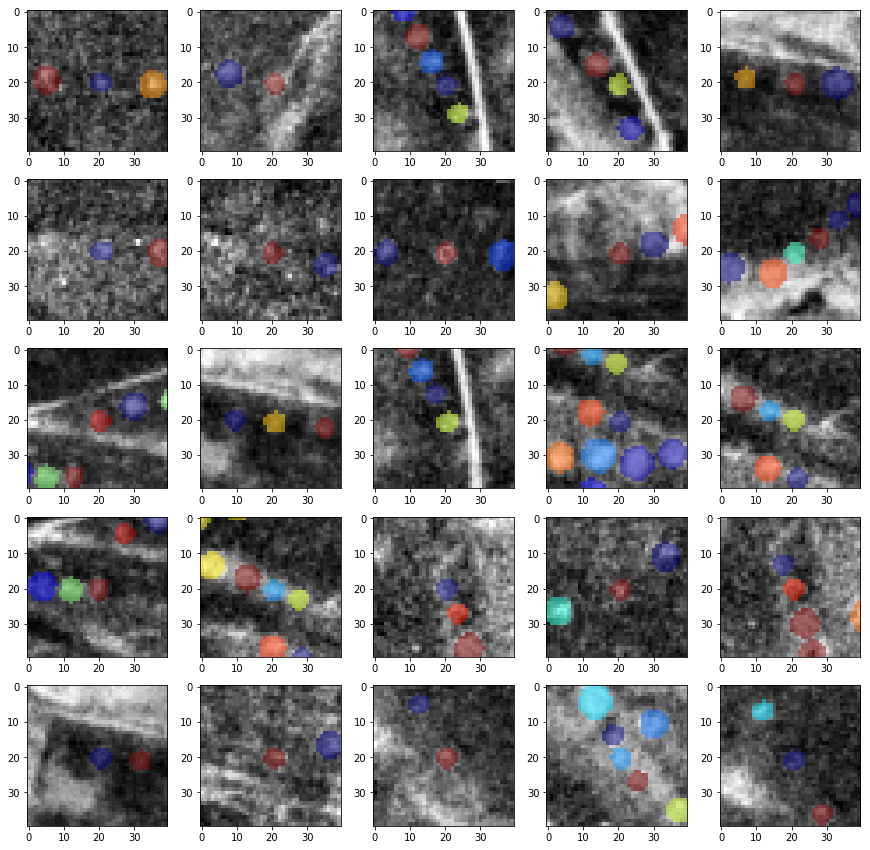

In [199]:
fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
pad = 20
axs = axs.ravel()
i = 0
for index, row in smallest.iterrows():
    x = row['x']
    y = row['y']
    label_val = row['label']
    axs[i].imshow(nda[-pad+y:pad+y, -pad+x:pad+x], cmap=plt.cm.gray)
    axs[i].imshow(label_mask[-pad+y:pad+y, -pad+x:pad+x], alpha=0.5, cmap=plt.cm.jet)
    i +=1

/home/mehrtash/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


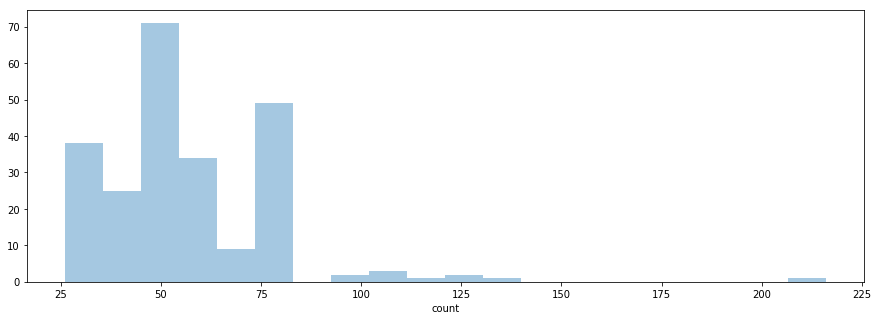

In [192]:
tmp_df = df[df.label != 618] # this is based on random ...
plt.figure(figsize=(15, 5))
sns.distplot(tmp_df['count'],  kde=False)

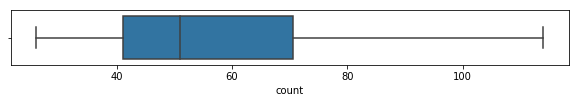

In [193]:
plt.figure(figsize=(10, 1))
sns.boxplot(df['count'],showfliers=False)